<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/Models_v3/VAE_Novel_NASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SETUP


#### Import and process data

Import Libraries

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.utils import class_weight
tf.autograph.set_verbosity(0)
from google.colab import drive
drive.mount('/content/drive/')

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/



Plot data function

In [0]:
def plot_images(data, image_to_plot):
    plot = plt.figure(figsize=[15,2])
    for i in range(img_channels):
        plt.subplot(1, img_channels, i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(data[image_to_plot][:,:,i], cmap=plt.cm.binary)
    plt.show()

Create dataset function







In [0]:
def setup_dataset(x):
  images = x/input_range

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images)).shuffle(len(images)).batch(batch_size)
  return dataset

#### Create Variational Autoencoder (VAE) Model

Make model

In [4]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Input((64, 64, 6)),                          
                          tf.keras.layers.Conv2D(12, (7,7), strides = (2,2), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Conv2D(8, (5,5), strides = (2,2), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Conv2D(6, (3,3), strides = (1,1), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ], name='Encoder')

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(768, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(16, 16, 3)),
                          tf.keras.layers.Conv2DTranspose(8, (3,3), strides = (1,1), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Conv2DTranspose(12, (5,5), strides = (2,2), padding = 'SAME'),
                          tf.keras.layers.Conv2DTranspose(6, (7,7), strides = (2,2), padding = 'SAME'),
                          ], name='Decoder')

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      
    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        return pixel_output

model = CVAE(768)
model.encoder_nn.summary()
model.decoder_nn.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 12)        3540      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 8)         2408      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 6)         438       
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1536)              2360832   
Total params: 2,367,218
Trainable params: 2,367,218
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Out

Define the loss function 

In [0]:
def calculate_ELBO(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  pixel_prob = tf.math.sigmoid(x_logit)

  variance = 0.2**2
  logpx_z = tf.reduce_sum(-.5 * (((x - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
  KL = -0.5*(tf.reduce_sum(tf.math.add(logvar,1), axis=1) - tf.reduce_sum(tf.exp(logvar), axis=1) - tf.reduce_sum(tf.exp(mean ** 2), axis=1))

  #print('recon = ' + str(tf.reduce_mean(logpx_z).numpy()))
  #print('KL = ' + str(tf.reduce_mean(KL).numpy()))

  return -tf.reduce_mean(logpx_z - KL)

Define the optimizer and metrics

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

Define train and test steps

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, optimizer):
    loss = calculate_ELBO(model, x)
    test_loss(loss)

def train_only_dataset(model, train_dataset, epochs):  
  for epoch in range(epochs):
    for train_x in train_dataset: 
      train_step(model, train_x, optimizer)

    loss = -train_loss.result()
     
  train_loss.reset_states()
  return loss

## TRAIN THE DATA

### Import and train the data

Import and randomize the data

In [0]:
typical_images = np.load('/content/drive/My Drive/SPACE_DATA/typical_images.npy')
novel_images = np.load('/content/drive/My Drive/SPACE_DATA/novel_images.npy')

test_idx = random.sample(range(0, 98800), 100)
train_idx = list(range(98800))
for i in test_idx:
  train_idx.remove(i)

typical_images_train = typical_images[train_idx]
typical_images_test = typical_images[test_idx]

test_idx = random.sample(range(0, 332), 32)
train_idx = list(range(332))
for i in test_idx:
  train_idx.remove(i)

novel_images_train = novel_images[train_idx]
novel_images_test = novel_images[test_idx]

np.save('/content/drive/My Drive/SPACE_DATA/typical_images_train.npy', typical_images_train)
np.save('/content/drive/My Drive/SPACE_DATA/typical_images_test.npy', typical_images_test)
np.save('/content/drive/My Drive/SPACE_DATA/novel_images_train.npy', novel_images_train)
np.save('/content/drive/My Drive/SPACE_DATA/novel_images_test.npy', novel_images_test)

typical_images = 0
novel_images = 0

Import previously randomized data

In [0]:
typical_images_train = np.load('/content/drive/My Drive/SPACE_DATA/typical_images_train.npy')
novel_images_train = np.load('/content/drive/My Drive/SPACE_DATA/novel_images_train.npy')
typical_images_test = np.load('/content/drive/My Drive/SPACE_DATA/typical_images_test.npy')
novel_images_test = np.load('/content/drive/My Drive/SPACE_DATA/novel_images_test.npy')

Define image sizes and numbers

In [0]:
N_typical_images_train = typical_images_train.shape[0]
N_typical_images_test = typical_images_test.shape[0]
N_novel_images_train = novel_images_train.shape[0]
N_novel_images_test = novel_images_test.shape[0]
img_height = typical_images_train.shape[1]
img_width = typical_images_train.shape[2]
img_channels = typical_images_train.shape[3]
input_range = np.amax(typical_images_train)

Train the data

In [0]:
z_size = 768
model = CVAE(z_size)

5.90---> 15832.8955


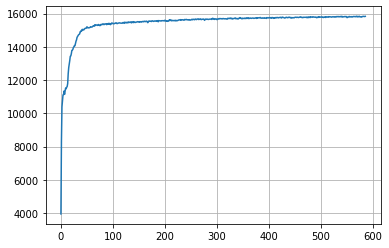

461.17728424072266


In [13]:
start_time = time.time()
losses = []
for j in range(6):
  typical_images_train = shuffle(typical_images_train, random_state=0)
  print(j)
  for i in range(99):
    train_dataset = setup_dataset(typical_images_train[i*1000:i*1000+1000].astype('float32'))
    loss = train_only_dataset(model, train_dataset, 1)
    losses = np.append(losses, loss.numpy())

    if i%10 == 0:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))
      plt.plot(range(len(losses)), losses)
      plt.grid(which='both', axis='both')
      plt.show()
print('TRAINING TIME = {}\n'.format(time.time()-start_time))

### Check the model works

Reconstruct images

(1, 64, 64, 6)
Original Pictures:


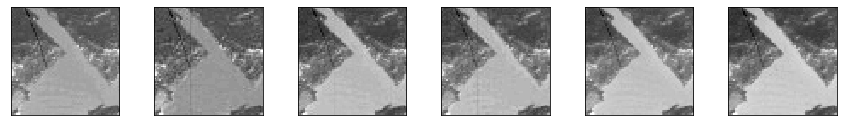

Reconstructed Pictures, with ELBO loss:


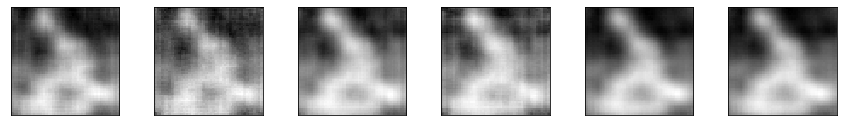

[15780.]


In [14]:
def reconstruct_images(model, data, images):
    images_n = 1
    x = data[images]/input_range
    x = x.reshape(images_n, img_height, img_width, img_channels).astype('float32')

    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    print(np.shape(pixel_prob))

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i] = -calculate_ELBO(model,x[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(data, images)
    print('Reconstructed Pictures, with ELBO loss:')
    plot_images(pixel_prob, 0)
    return loss

loss = reconstruct_images(model, typical_images_train, 2)
print(loss)

Visualize the latent space

1.5901191234588623


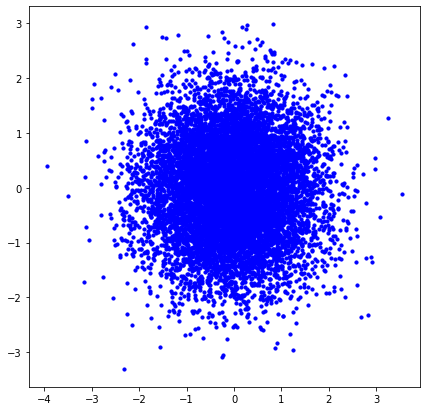

In [15]:
def visualize_latent_space(model, images, data_x, dimensions):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  outlier = []
  data_x = data_x[images[0]:images[1]]
  latent_space = np.ndarray([0, model.z_size])
  for i in range((images[1]-images[0])//1000 +1):
      x = data_x[i*1000:i*1000+1000].astype('float32')
      x = x/input_range
      z_mean, z_logvar = model.encode(x)
      z = model.reparameterize(z_mean, z_logvar)
      latent_space = np.append(latent_space, z, axis=0)


  plt.scatter(latent_space[:, dimensions[0]], latent_space[:,dimensions[1]], color = 'blue', s=10)

  return latent_space, outlier

start_time = time.time()
latent_space, outlier = visualize_latent_space(model, [0, 10000], typical_images_train, [0,1])
print(time.time()-start_time)

## PREDICT NOVELTIES WITH THRESHOLD

#### Define novelty functions

Loss_1 = Deterministic reconstruction error

Loss_2 = Encoder-stochastic reconstruction error average

Loss_3 = Encoder-stochastic reconstruction error minimum

Loss_4 = Deterministic reconstruction likelihood

Loss_5 = Encoder-stochastic reconstruction likelihood average

Loss_6 = Encoder-stochastic reconstruction likelihood minimum

Loss_7 = Fully deterministic distance-based reconstruction error

Loss_8 = Test deterministic distance-based reconstruction error

Loss_9 = Train deterministic distance-based reconstruction error

Loss_10 = Bhattacharyya distance of deterministic reconstruction likelihood

Loss_11 = ELBO

Loss_12 = ELBO average

Loss_13 = ELBO minimum

Loss_14 = KL Divergence

Loss_15 = Euclidean distance between means of the distributions

Loss_16 = Bhattacharyya distance between distributions

Loss_17 = Density latent space 

In [0]:
def Loss_1(model, x):
  losses_per_image = []
  for images in x:

    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)

    pixel_squared = tf.math.square(pixel_prob - images)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, pixel_squared)
  return losses_per_image

def Loss_2(model, x):
  losses_per_image = []
  for images in x:

    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_3(model, x):
  losses_per_image = []
  for images in x:

    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_4(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)

    variance = 0.2**2
    logpx_z = tf.reduce_sum(-.5 * (((images - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * 3.14)), axis=[1, 2, 3])
    losses_per_image = np.append(losses_per_image, logpx_z)
  return -losses_per_image

def Loss_5(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      variance = 0.2**2
      logpx_z = tf.reduce_sum(-.5 * (((images - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
      avg[j,:] = logpx_z
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return -losses_per_image

def Loss_6(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      variance = 0.2**2
      logpx_z = tf.reduce_sum(-.5 * (((images - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
      avg[j,:] = logpx_z
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return -losses_per_image

def Loss_7(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_7:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_8(model, x_train, x_test):
  losses_per_image = []
  image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    if a != 0: image_train = np.append(image_train, images, axis=0)
    else: image_train = images; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_9(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: image_test = np.append(image_test, images, axis=0)
    else: image_test = images; b = 1  
  num = len(image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_10:{}%'.format(100*(i)/num))
    temporary = np.abs(image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_10(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_8:{}%'.format(100*(i)/num))
    temporary = np.sqrt(np.multiply(1-pixel_prob_per_image_test[i],np.subtract(1,pixel_prob_per_image_train)))+np.sqrt(np.multiply(pixel_prob_per_image_test[i],pixel_prob_per_image_train))
    temporary = np.log(temporary)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_11(model, x):
  losses_per_image = -Loss_4(model, x)-Loss_14(model, x)
  return -losses_per_image

def Loss_12(model, x):
  losses_per_image = -Loss_5(model, x)-Loss_14(model, x)
  return -losses_per_image

def Loss_13(model, x):
  losses_per_image = -Loss_6(model, x)-Loss_14(model, x)
  return -losses_per_image

def Loss_14(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)

    KL = -0.5*(tf.reduce_sum(tf.math.add(z_logvar,1), axis=1) - tf.reduce_sum(tf.exp(z_logvar), axis=1) - tf.reduce_sum(tf.exp(z_mean ** 2), axis=1))
    losses_per_image = np.append(losses_per_image, KL)
  return -losses_per_image

def Loss_15(model, x_train, x_test):
  losses_per_image = []
  z_mean_per_image_train = []
  z_mean_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: z_mean_per_image_train = np.append(z_mean_per_image_train, z_mean, axis=0)
    else: z_mean_per_image_train = z_mean; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_per_image_test = np.append(z_mean_per_image_test, z_mean, axis=0)
    else: z_mean_per_image_test = z_mean; b = 1 
  num = len(z_mean_per_image_test)
  for i in range(num):
    if not i%500: clear_output(); print('Progress Loss_15:{}%'.format(100*(i)/num))
    temporary = np.abs(z_mean_per_image_test[i] - z_mean_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=1)
    losses_per_image = np.append(losses_per_image, np.min(temporary)) 
  return losses_per_image

def Loss_16(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []; z_var_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: 
      z_mean_test = np.append(z_mean_test, z_mean, axis=0)
      z_var_test = np.append(z_var_test, np.exp(z_logvar), axis=0)
    else: 
      z_mean_test = z_mean
      z_var_test = np.exp(z_logvar)
      b = 1 
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_16:{}%'.format(100*(i)/num))
    temporary_1 = np.log(np.multiply(0.25, (np.add(np.divide(z_var_test[i], z_var_train), np.add(np.divide(z_var_train, z_var_test[i]),2)))))
    temporary_2 = np.divide(np.square(np.subtract(z_mean_test[i], z_mean_train)), np.add(z_var_test[i], z_var_train))
    temporary = np.multiply(0.25, temporary_1) + np.multiply(0.25, temporary_2)
    losses_per_image = np.append(losses_per_image, np.min(np.sum(temporary)))
  return losses_per_image

def Loss_17(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_test = np.append(z_mean_test, z_mean, axis=0)
    else: z_mean_test = z_mean; b = 1 
  
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_17:{}%'.format(100*(i)/num))
    A = np.divide(0.39894, np.sqrt(z_var_train))
    B1 = np.subtract(z_mean_test[i], z_mean_train)
    B2 = np.sqrt(z_var_train)
    B = np.multiply(-0.5, np.square(np.divide(B1,B2)))
    temporary = np.multiply(A, np.exp(B))
    temporary = np.mean(temporary)
    losses_per_image = np.append(losses_per_image, temporary) 
  return -losses_per_image

In [0]:
Loss_functions_dict = dict([(1,Loss_1),(2,Loss_2),(3,Loss_3),(4,Loss_4),(5,Loss_5),(6,Loss_6),(7,Loss_7),
                            (8,Loss_8),(9,Loss_9),(10,Loss_10),(11,Loss_11),(12,Loss_12),(13,Loss_13),
                            (14,Loss_14),(15,Loss_15),(16,Loss_16),(17,Loss_17)])

### Classify with untrained ROC curve

In [0]:
def threshold_ROC(y_true, y_score, title, plot=True):
  fpr, tpr, threshold = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
  optimal_threshold = threshold[optimal_idx]

  optimal_accuracy_idx = np.argmax(tpr*300+((1-fpr)*98700))
  optimal_accuracy = (tpr[optimal_accuracy_idx]*300+((1-fpr[optimal_accuracy_idx])*98700))/99000
  optimal_accuracy_threshold = threshold[optimal_accuracy_idx]

  optimal_avgaccuracy_idx = np.argmax(tpr + 1 - fpr)
  optimal_avgaccuracy = (tpr[optimal_avgaccuracy_idx]+1-fpr[optimal_avgaccuracy_idx])/2
  optimal_avgaccuracy_threshold = threshold[optimal_avgaccuracy_idx]

  if plot:
    plot = plt.figure()
    plt.plot(fpr, tpr, color='red', label='AUC = %0.2f; Threshold = %0.4f' % (roc_auc,optimal_threshold))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + title)
    plt.legend(loc="lower right")
    plt.show()
  return roc_auc, optimal_threshold, optimal_accuracy, optimal_accuracy_threshold, optimal_avgaccuracy, optimal_avgaccuracy_threshold

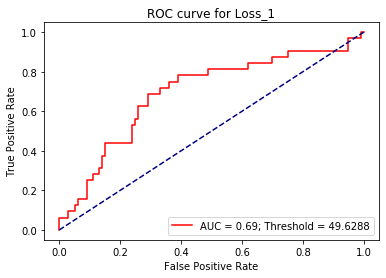

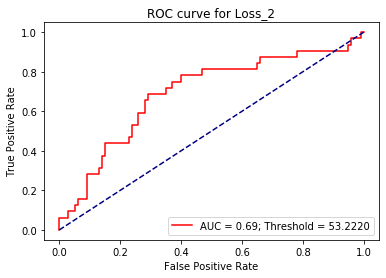

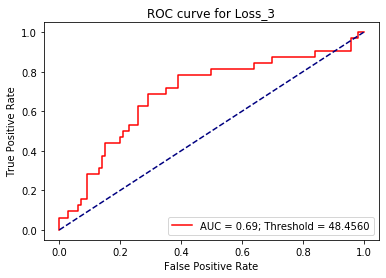

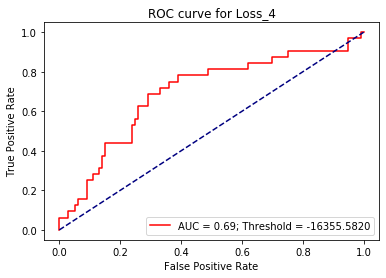

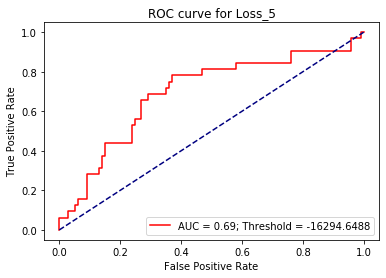

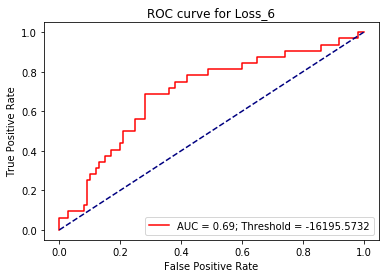

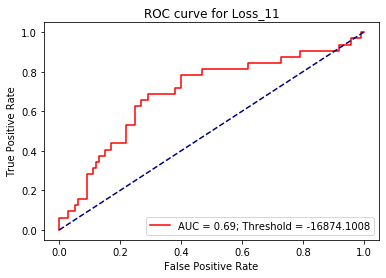

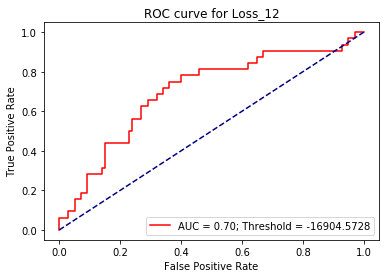

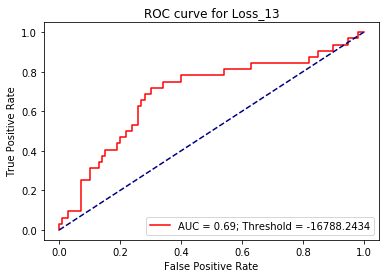

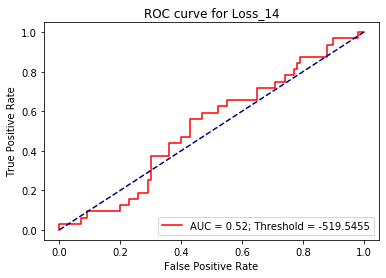

In [27]:
threshold_dict = dict([])
threshold_avg_dict = dict([])
auc_dict = dict([])
y_predicted_dict = dict([])

table_of_counts_dict = dict([])
accuracy_dict = dict([])
avg_accuracy_dict = dict([])

for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
    dataset = setup_dataset(novel_images_test.astype('float32'))
    losses = Loss_functions_dict[i](model, dataset)
    dataset = setup_dataset(typical_images_test.astype('float32'))
    losses = np.append(losses, Loss_functions_dict[i](model, dataset))
    y_true = np.zeros([len(losses),])
    y_true[0:32] = 1
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_true, losses, 'Loss_'+str(i), plot=True)
    y_predicted_dict[i] = np.zeros([len(losses),])
    y_predicted_dict[i][np.where(losses > threshold_avg_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy

In [29]:
result_table = np.empty([10,7])
index = ['_']*10
j = 0
for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
  result_table[j,0] = "{0:.1f}".format(accuracy_dict[i]*100)
  result_table[j,1] = "{0:.1f}".format(avg_accuracy_dict[i]*100)
  result_table[j,2] = table_of_counts_dict[i][1,1].astype('int')
  result_table[j,3] = table_of_counts_dict[i][0,1].astype('int')
  result_table[j,4] = table_of_counts_dict[i][0,0].astype('int')
  result_table[j,5] = table_of_counts_dict[i][1,0].astype('int')
  result_table[j,6] = "{0:.1f}".format(auc_dict[i]*100)
  index[j] = 'Loss_'+str(i)
  j +=1
df = pd.DataFrame(result_table, index=index, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True neg.', 'False Neg.', 'AUC',])
df.astype(str).replace('\.0', '', regex=True)

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True neg.,False Neg.,AUC
Loss_1,69.7,68.3,21,29,71,11,69.3
Loss_2,69.7,68.3,21,29,71,11,69.2
Loss_3,69.7,68.3,21,29,71,11,68.9
Loss_4,69.7,68.3,21,29,71,11,69.3
Loss_5,65.9,69,24,37,63,8,69.2
Loss_6,70.5,68.8,21,28,72,11,69.4
Loss_11,69.7,68.3,21,29,71,11,69.3
Loss_12,65.9,67.9,23,36,64,9,69.8
Loss_13,69.7,69.4,22,30,70,10,69.1
Loss_14,56.1,55.1,17,43,57,15,52.2


### Compute novelty scores for training images

In [54]:
losses_typical = dict([])
losses_novel = dict([])

for j in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
  start_time = time.time()

  losses_typical[j] = []
  print('LOSS {} Pogress/20: '.format(j), end='')
  for i in range(20):
    print('{}, '.format(i+1), end='')
    dataset = setup_dataset(typical_images_train[i*5000:i*5000+5000].astype('float32'))
    losses_typical[j] = np.append(losses_typical[j], Loss_functions_dict[j](model, dataset))

  print('novel')
  dataset = setup_dataset(novel_images_train.astype('float32'))
  losses_novel[j] = Loss_functions_dict[j](model, dataset)

  print('LOSS {} Time ---> {} sec \n'.format(j, time.time()-start_time))

LOSS 1 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 1 Time ---> 37.11826682090759 sec 

LOSS 2 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 2 Time ---> 554.8263549804688 sec 

LOSS 3 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 3 Time ---> 552.7745263576508 sec 

LOSS 4 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 4 Time ---> 36.824498414993286 sec 

LOSS 5 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 5 Time ---> 334.6028435230255 sec 

LOSS 6 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 6 Time ---> 342.05461168289185 sec 

LOSS 11 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 11 Time ---> 58.14826965332031 sec 

LOSS 12 Pogress/20: 1, 2, 3, 4, 5, 6,

In [0]:
np.save('/content/drive/My Drive/SPACE_DATA/losses_typical_dict.npy',losses_typical)
np.save('/content/drive/My Drive/SPACE_DATA/losses_novel_dict.npy',losses_novel)

In [0]:
losses_typical_dict = np.load('/content/drive/My Drive/SPACE_DATA/losses_typical_dict.npy', allow_pickle=True)
losses_typical_dict = losses_typical_dict.item()
losses_novel_dict = np.load('/content/drive/My Drive/SPACE_DATA/losses_novel_dict.npy', allow_pickle=True)
losses_novel_dict = losses_novel_dict.item()

### Classify with trained ROC curve

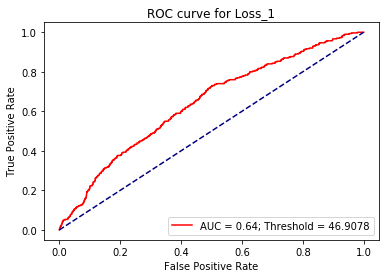

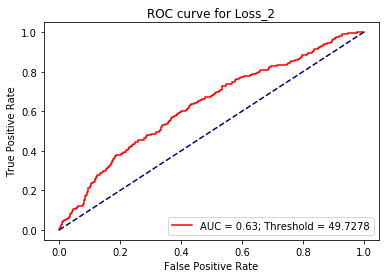

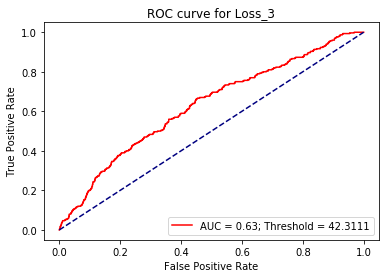

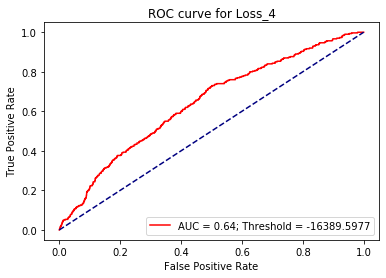

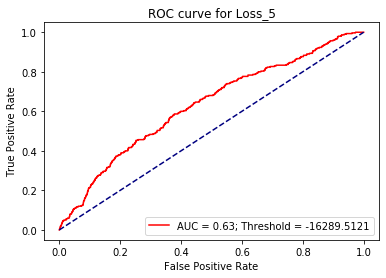

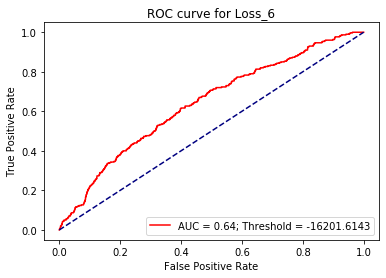

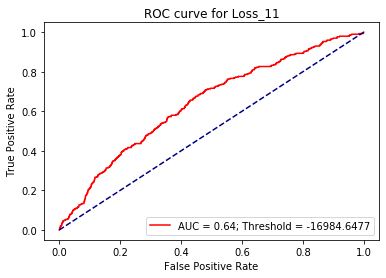

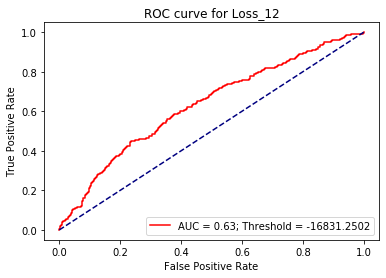

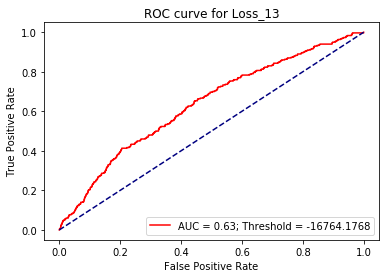

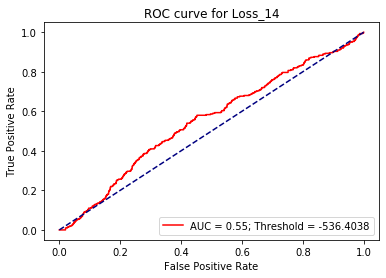

In [33]:
threshold_dict = dict([])
threshold_avg_dict = dict([])
auc_dict = dict([])
y_predicted_dict = dict([])

table_of_counts_dict = dict([])
accuracy_dict = dict([])
avg_accuracy_dict = dict([])

for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
    y_train = np.zeros([len(losses_novel_dict[1])+len(losses_typical_dict[1]),])
    y_train[0:300] = 1
    losses_train = np.append(losses_novel_dict[i], losses_typical_dict[i])
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_train, losses_train, 'Loss_'+str(i), plot=True)

    dataset = setup_dataset(novel_images_test.astype('float32'))
    losses = Loss_functions_dict[i](model, dataset)
    dataset = setup_dataset(typical_images_test.astype('float32'))
    losses = np.append(losses, Loss_functions_dict[i](model, dataset))
    y_true = np.zeros([len(losses),])
    y_true[0:32] = 1
    y_predicted_dict[i] = np.zeros([len(losses),])
    y_predicted_dict[i][np.where(losses > threshold_avg_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy

In [34]:
result_table = np.empty([10,7])
index = ['_']*10
j = 0
for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
  result_table[j,0] = "{0:.1f}".format(accuracy_dict[i]*100)
  result_table[j,1] = "{0:.1f}".format(avg_accuracy_dict[i]*100)
  result_table[j,2] = table_of_counts_dict[i][1,1].astype('int')
  result_table[j,3] = table_of_counts_dict[i][0,1].astype('int')
  result_table[j,4] = table_of_counts_dict[i][0,0].astype('int')
  result_table[j,5] = table_of_counts_dict[i][1,0].astype('int')
  result_table[j,6] = "{0:.2f}".format(auc_dict[i]*100)
  index[j] = 'Loss_'+str(i)
  j +=1
df = pd.DataFrame(result_table, index=index, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True neg.', 'False Neg.', 'AUC',])
df.astype(str).replace('\.0', '', regex=True)

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True neg.,False Neg.,AUC
Loss_1,62.1,67.6,25,43,57,7,63.96
Loss_2,67.4,67.9,22,33,67,10,631
Loss_3,65.2,67.4,23,37,63,9,62.78
Loss_4,62.1,67.6,25,43,57,7,63.96
Loss_5,69.7,68.3,21,29,71,11,631
Loss_6,68.2,67.3,21,31,69,11,63.84
Loss_11,61.4,67.1,25,44,56,7,649
Loss_12,72.7,60.7,12,16,84,20,63.18
Loss_13,72,58.1,10,15,85,22,63.41
Loss_14,39.4,50.4,23,71,29,9,55.22


### Classify using classifier

In [39]:
threshold_dict = dict([])
threshold_avg_dict = dict([])
auc_dict = dict([])
y_predicted_dict = dict([])
predictions_dict = dict([])

table_of_counts_dict = dict([])
accuracy_dict = dict([])
avg_accuracy_dict = dict([])

start_time = time.time()
for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
    print('TRAINING MODEL WITH LOSS ' + str(i))
    classifier = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(1,)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

    y_train = np.zeros([len(losses_novel_dict[1])+len(losses_typical_dict[1]),])
    y_train[0:300] = 1
    losses_train = np.append(losses_novel_dict[i], losses_typical_dict[i])
    losses_train=losses_train/np.max(losses_train)

    class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)))
    classifier.fit(losses_train, y_train, batch_size=100, epochs=10, class_weight=class_weights, shuffle=True)

    dataset = setup_dataset(novel_images_test.astype('float32'))
    losses_test = Loss_functions_dict[i](model, dataset)
    dataset = setup_dataset(typical_images_test.astype('float32'))
    losses_test = np.append(losses_test, Loss_functions_dict[i](model, dataset))
    losses_test = losses_test/np.max(losses_test)
    predictions_dict[i] = classifier.predict(losses_test)
    predictions_dict[i] = predictions_dict[i].reshape([len(predictions)])
print('TRAINING TIME = {}\n'.format(time.time()-start_time))

TRAINING MODEL WITH LOSS 1
  ...
    to  
  ['...']
Train on 99000 samples
Epoch 1/10
99000/99000 [==============================] - 4s 37us/sample - loss: 0.6898 - binary_accuracy: 0.5060
Epoch 2/10
99000/99000 [==============================] - 3s 34us/sample - loss: 0.6820 - binary_accuracy: 0.5056
Epoch 3/10
99000/99000 [==============================] - 3s 33us/sample - loss: 0.6764 - binary_accuracy: 0.6288
Epoch 4/10
99000/99000 [==============================] - 3s 34us/sample - loss: 0.6734 - binary_accuracy: 0.6612
Epoch 5/10
99000/99000 [==============================] - 3s 34us/sample - loss: 0.6720 - binary_accuracy: 0.6920
Epoch 6/10
99000/99000 [==============================] - 3s 33us/sample - loss: 0.6718 - binary_accuracy: 0.6978
Epoch 7/10
99000/99000 [==============================] - 3s 34us/sample - loss: 0.6711 - binary_accuracy: 0.6649
Epoch 8/10
99000/99000 [==============================] - 3s 34us/sample - loss: 0.6706 - binary_accuracy: 0.6863
Epoch 9/10
99

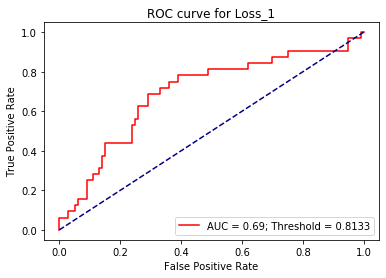

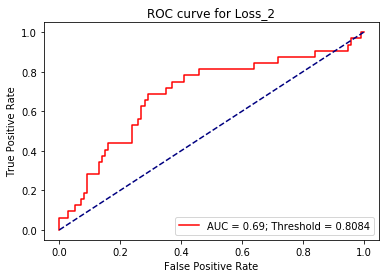

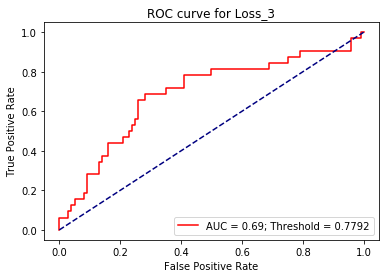

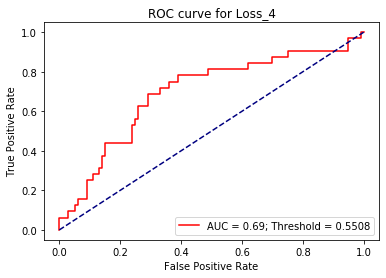

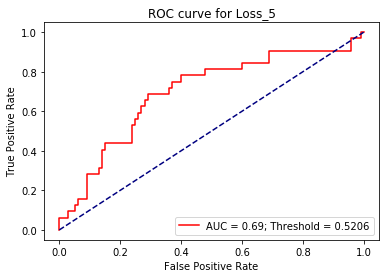

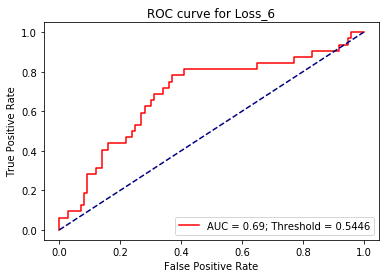

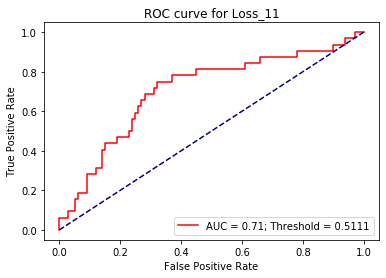

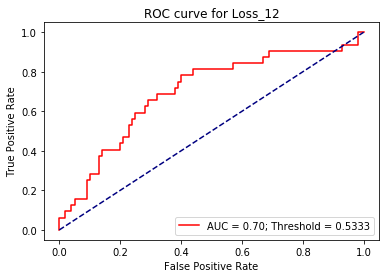

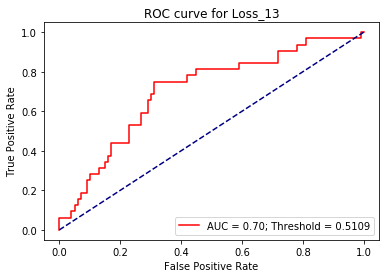

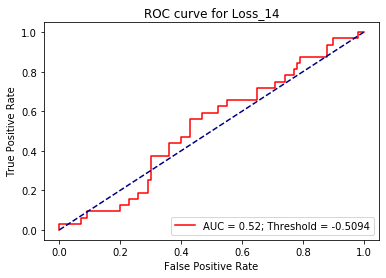

In [64]:
for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:  
    y_true = np.zeros([len(losses_test),])
    y_true[0:32] = 1
    if i == 14:
      predictions_dict[i] = -predictions_dict[i]
    
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_true, predictions_dict[i], 'Loss_'+str(i), plot=True)      

    y_predicted_dict[i] = np.zeros([len(predictions_dict[i]),])
    y_predicted_dict[i][np.where(predictions_dict[i] > threshold_avg_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses_test),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses_test)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy

In [65]:
result_table = np.empty([10,7])
index = ['_']*10
j = 0
for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
  result_table[j,0] = "{0:.1f}".format(accuracy_dict[i]*100)
  result_table[j,1] = "{0:.1f}".format(avg_accuracy_dict[i]*100)
  result_table[j,2] = table_of_counts_dict[i][1,1].astype('int')
  result_table[j,3] = table_of_counts_dict[i][0,1].astype('int')
  result_table[j,4] = table_of_counts_dict[i][0,0].astype('int')
  result_table[j,5] = table_of_counts_dict[i][1,0].astype('int')
  result_table[j,6] = "{0:.1f}".format(auc_dict[i]*100)
  index[j] = 'Loss_'+str(i)
  j +=1
df = pd.DataFrame(result_table, index=index, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True neg.', 'False Neg.', 'AUC',])
df.astype(str).replace('\.0', '', regex=True)

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True neg.,False Neg.,AUC
Loss_1,69.7,68.3,21,29,71,11,69.3
Loss_2,69.7,68.3,21,29,71,11,68.8
Loss_3,70.5,68.8,21,28,72,11,68.8
Loss_4,69.7,68.3,21,29,71,11,69.3
Loss_5,69.7,68.3,21,29,71,11,69.5
Loss_6,65.9,69,24,37,63,8,69
Loss_11,68.9,69.9,23,32,68,9,70.6
Loss_12,63.6,67.5,24,40,60,8,69.7
Loss_13,69.7,70.4,23,31,69,9,70.3
Loss_14,56.1,55.1,17,43,57,15,52.2


## Predict Novelties with NN

### Define novelty functions

Loss_1 = Deterministic reconstruction error

Loss_2 = Encoder-stochastic reconstruction error average

Loss_3 = Encoder-stochastic reconstruction error minimum

Loss_4 = Deterministic reconstruction likelihood

Loss_5 = Encoder-stochastic reconstruction likelihood average

Loss_6 = Encoder-stochastic reconstruction likelihood minimum

Loss_7 = Fully deterministic distance-based reconstruction error

Loss_8 = Test deterministic distance-based reconstruction error

Loss_9 = Train deterministic distance-based reconstruction error

Loss_10 = Bhattacharyya distance of deterministic reconstruction likelihood

Loss_11 = ELBO

Loss_12 = ELBO average

Loss_13 = ELBO minimum

Loss_14 = KL Divergence

Loss_15 = Euclidean distance between means of the distributions

Loss_16 = Bhattacharyya distance between distributions

Loss_17 = Density latent space 

In [0]:
def Loss_1_img(model, x):
  losses_per_image = np.empty((0, 64, 64))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_squared = np.square(pixel_prob - images)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[3])
    losses_per_image = np.append(losses_per_image, pixel_squared, axis=0)
  return losses_per_image

def Loss_2(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_3(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_4(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
    logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    losses_per_image = np.append(losses_per_image, logpx_z_images)
  return losses_per_image

def Loss_5(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
      logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
      avg[j,:] = logpx_z_images
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_6(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
      logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
      avg[j,:] = logpx_z_images
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_7(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_7:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_8(model, x_train, x_test):
  losses_per_image = []
  image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    if a != 0: image_train = np.append(image_train, images, axis=0)
    else: image_train = images; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_9(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: image_test = np.append(image_test, images, axis=0)
    else: image_test = images; b = 1  
  num = len(image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_10:{}%'.format(100*(i)/num))
    temporary = np.abs(image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_10(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_8:{}%'.format(100*(i)/num))
    temporary = np.sqrt(np.multiply(1-pixel_prob_per_image_test[i],np.subtract(1,pixel_prob_per_image_train)))+np.sqrt(np.multiply(pixel_prob_per_image_test[i],pixel_prob_per_image_train))
    temporary = np.log(temporary)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_11(model, x):
  losses_per_image = Loss_4(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_12(model, x):
  losses_per_image = Loss_5(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_13(model, x):
  losses_per_image = Loss_6(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_14(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    KL_parameters = 0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    losses_per_image = np.append(losses_per_image, KL_vectors)
  return losses_per_image

def Loss_15(model, x_train, x_test):
  losses_per_image = []
  z_mean_per_image_train = []
  z_mean_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: z_mean_per_image_train = np.append(z_mean_per_image_train, z_mean, axis=0)
    else: z_mean_per_image_train = z_mean; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_per_image_test = np.append(z_mean_per_image_test, z_mean, axis=0)
    else: z_mean_per_image_test = z_mean; b = 1 
  num = len(z_mean_per_image_test)
  for i in range(num):
    if not i%500: clear_output(); print('Progress Loss_15:{}%'.format(100*(i)/num))
    temporary = np.abs(z_mean_per_image_test[i] - z_mean_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=1)
    losses_per_image = np.append(losses_per_image, np.min(temporary)) 
  return losses_per_image

def Loss_16(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []; z_var_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: 
      z_mean_test = np.append(z_mean_test, z_mean, axis=0)
      z_var_test = np.append(z_var_test, np.exp(z_logvar), axis=0)
    else: 
      z_mean_test = z_mean
      z_var_test = np.exp(z_logvar)
      b = 1 
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_16:{}%'.format(100*(i)/num))
    temporary_1 = np.log(np.multiply(0.25, (np.add(np.divide(z_var_test[i], z_var_train), np.add(np.divide(z_var_train, z_var_test[i]),2)))))
    temporary_2 = np.divide(np.square(np.subtract(z_mean_test[i], z_mean_train)), np.add(z_var_test[i], z_var_train))
    temporary = np.multiply(0.25, temporary_1) + np.multiply(0.25, temporary_2)
    losses_per_image = np.append(losses_per_image, np.min(np.sum(temporary)))
  return losses_per_image

def Loss_17(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_test = np.append(z_mean_test, z_mean, axis=0)
    else: z_mean_test = z_mean; b = 1 
  
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_17:{}%'.format(100*(i)/num))
    A = np.divide(0.39894, np.sqrt(z_var_train))
    B1 = np.subtract(z_mean_test[i], z_mean_train)
    B2 = np.sqrt(z_var_train)
    B = np.multiply(-0.5, np.square(np.divide(B1,B2)))
    temporary = np.multiply(A, np.exp(B))
    temporary = np.mean(temporary)
    losses_per_image = np.append(losses_per_image, temporary) 
  return -losses_per_image

In [76]:
losses_typical_img = dict([])
losses_novel_img = dict([])

for j in [1]:
  start_time = time.time()
  
  losses_typical_img[j] = np.empty((0, 64, 64))
  print('LOSS {} Pogress/20: '.format(j), end='')
  for i in range(20):
    print('{}, '.format(i+1), end='')
    if i != 19: num = 5000
    if i == 19: num = 3700
    dataset = setup_dataset(typical_images[i*5000:i*5000+num].astype('float32'))
    losses_typical_img[j] = np.append(losses_typical_img[j], Loss_1_img(model, dataset), axis=0)

  print('novel')
  dataset = setup_dataset(novel_images[0:300].astype('float32'))
  losses_novel_img[j] = Loss_1_img(model, dataset)

  print('LOSS {} Time ---> {} sec \n'.format(j, time.time()-start_time))

LOSS 1 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 1 Time ---> 114.3452787399292 sec 



In [0]:
print(np.shape(losses_typical_img[1]))
print(np.shape(losses_novel_img[1]))

(98700, 32, 32)
(300, 32, 32)


In [0]:
from sklearn.utils import class_weight

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (32, 32, 1)) ,                        
    tf.keras.layers.Conv2D(16, (2,2), activation='relu'),
    tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

train_labels = np.ones([300+98700])*0
train_labels[0:300] = 1

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict([(0,class_weights[0]),(1,class_weights[1])])

losses_novel_img[1] = np.reshape(losses_novel_img[1], (300, 32, 32, 1))
losses_typical_img[1] = np.reshape(losses_typical_img[1], (98700, 32, 32, 1))

model.fit(np.append(losses_novel_img[1], losses_typical_img[1][0:98700], axis=0), train_labels, epochs=15, class_weight=class_weights, shuffle=True)

  ...
    to  
  ['...']
Train on 99000 samples
Epoch 1/15
99000/99000 [==============================] - 18s 177us/sample - loss: 0.8194 - accuracy: 0.3538
Epoch 2/15
99000/99000 [==============================] - 17s 172us/sample - loss: 0.6890 - accuracy: 0.4578
Epoch 3/15
99000/99000 [==============================] - 17s 172us/sample - loss: 0.9775 - accuracy: 0.3431
Epoch 4/15
99000/99000 [==============================] - 17s 171us/sample - loss: 0.7528 - accuracy: 0.3615
Epoch 5/15
99000/99000 [==============================] - 17s 175us/sample - loss: 0.7082 - accuracy: 0.3832
Epoch 6/15
99000/99000 [==============================] - 17s 171us/sample - loss: 0.6186 - accuracy: 0.5733
Epoch 7/15
99000/99000 [==============================] - 17s 171us/sample - loss: 0.5147 - accuracy: 0.7008
Epoch 8/15
99000/99000 [==============================] - 17s 170us/sample - loss: 0.3820 - accuracy: 0.7903
Epoch 9/15
99000/99000 [==============================] - 17s 170us/sample - los

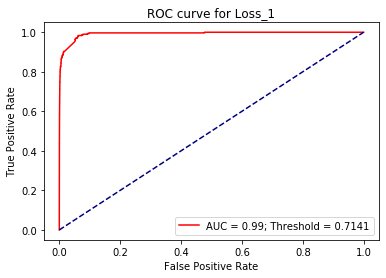

0.71410066
0.9603292806484296
0.6549577


In [0]:
predictions = model.predict(np.append(losses_novel_img[1], losses_typical_img[1][0:98700], axis=0))
_, threshold, _, _, avg_accuracy, threshold_avg_accuracy = threshold_ROC(train_labels, predictions, 'Loss_1', plot=True)
print(threshold)
print(avg_accuracy)
print(threshold_avg_accuracy)

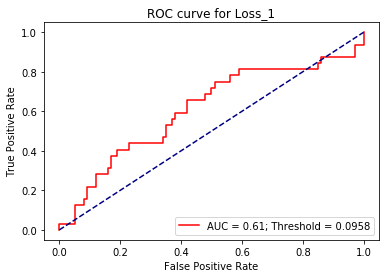

0.09582361
0.62
0.06290757


In [0]:
dataset = setup_dataset(novel_images[300:332].astype('float32'))
test_images = Loss_1_img(CVAE_25, dataset)
dataset = setup_dataset(typical_images[98700:98800].astype('float32'))
test_images = np.append(test_images, Loss_1_img(CVAE_25, dataset), axis=0)
test_images = np.reshape(test_images, (132, 32, 32, 1))

test_labels = np.zeros([len(test_images),])
test_labels[0:32] = 1

predictions = model.predict(test_images)

_, threshold, _, _, avg_accuracy, threshold_avg_accuracy = threshold_ROC(test_labels, predictions, 'Loss_1', plot=True)
print(threshold)
print(avg_accuracy)
print(threshold_avg_accuracy)

In [0]:
predictions[predictions > 0.65] = 1
predictions[predictions < 0.65] = 0

def check_results(y_true, y_predicted):
  table_of_counts = np.zeros([2,2])
  for i in range(len(y_true),):
    if y_true[i] == 0:
      if y_predicted[i] == 0:
        table_of_counts[0,0] += 1
      else: table_of_counts[0,1] += 1
    if y_true[i] == 1:
      if y_predicted[i] == 0:
        table_of_counts[1,0] += 1
      else: table_of_counts[1,1] += 1

  true_positive = table_of_counts[1,1]
  false_positive = table_of_counts[0,1]
  true_negative = table_of_counts[0,0]
  false_negative = table_of_counts[1,0]

  accuracy = (true_positive+true_negative)/len(y_true)
  avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

  return table_of_counts, accuracy, avg_accuracy

table_of_counts, accuracy, avg_accuracy = check_results(test_labels, predictions)

In [0]:
print(table_of_counts)
print(accuracy)
print(avg_accuracy)

[[49. 51.]
 [ 9. 23.]]
0.5454545454545454
0.604375


In [0]:
result_table = np.empty([1,6])
index = ['_']*1
result_table[0,0] = "{0:.2f}".format(accuracy*100)
result_table[0,1] = "{0:.2f}".format(avg_accuracy*100)
result_table[0,2] = table_of_counts[1,1].astype('int')
result_table[0,3] = table_of_counts[0,1].astype('int')
result_table[0,4] = table_of_counts[0,0].astype('int')
result_table[0,5] = table_of_counts[1,0].astype('int')
index = 'Loss_1'
df = pd.DataFrame(result_table, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True Neg.', 'False Neg.',])
df.astype(str).replace('\.0', '', regex=True)

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True Neg.,False Neg.
0,54.55,60.44,23,51,49,9
